Reference: https://github.com/hlamba28/Offline-Signature-Verification-using-Siamese-Network/blob/master/SigNet-BHSig260.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !git clone https://github.com/sounakdey/SigNet.git /content/drive/MyDrive/SignatureVerificationCylab/SigNet

In [ ]:
%cd /content/drive/MyDrive/SignatureVerificationCylab/SigNet

/content/drive/MyDrive/SignatureVerificationCylab/SigNet


In [ ]:
# !mkdir /content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset

In [ ]:
# !unzip /content/drive/MyDrive/SignatureVerificationCylab/cedar_dataset.zip -d /content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
import os

#from keras.utils.visualize_util import plot

# import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
# from keras.preprocessing import image
import keras.utils as image
from keras import backend as K
import sys
import glob
import logging
from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop, Adadelta
from tensorflow.keras.layers import BatchNormalization
# from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
import random
random.seed(1337)


In [ ]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

# import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Dense, Dropout, Input, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
# from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Sequential, Model

from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

# from keras.engine.topology import Layer
from tensorflow.keras.layers import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# Create a session for running Ops on the Graph.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

logging.basicConfig(level=logging.WARNING)
log = logging.getLogger()


In [ ]:
# from keras.engine import base_layer_utils
base_path = "/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/"

In [ ]:
# Get the list of all directories and sort them
dir_list = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path,folder))]
dir_list.sort()

dir_list = dir_list[1:]

In [ ]:
print(dir_list)

['full_forg', 'full_org']


In [ ]:
# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
num = 24 # Number of genuine or forged

def split_into_batches(input_list, num_images):
    for i in range(0, len(input_list), num_images):
        yield input_list[i:i + num_images]

for directory in dir_list:
    images = os.listdir(base_path+directory)
    images.sort()
    images = [base_path+directory+'/'+x for x in images if x != "Thumbs.db"]

    batches = list(split_into_batches(images, num))

    if directory == "full_forg":
        forg_groups.append(batches) # First 24 signatures in each folder are forrged
    elif directory == "full_org":
        orig_groups.append(batches)




In [ ]:
len(orig_groups[0])

55

In [ ]:

len(forg_groups[0])

55

In [ ]:
orig_groups;

In [ ]:
orig_lengths = [len(x) for x in orig_groups[0]]
forg_lengths = [len(x) for x in forg_groups[0]]

In [ ]:
orig_lengths, forg_lengths;

In [ ]:
orig_train, orig_val, orig_test = orig_groups[0][:30], orig_groups[0][30:40], orig_groups[0][40:55]
forg_train, forg_val, forg_test = forg_groups[0][:30], forg_groups[0][30:40], forg_groups[0][40:55]

In [ ]:
orig_train

[['/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_org/original_10_1.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_org/original_10_10.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_org/original_10_11.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_org/original_10_12.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_org/original_10_13.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_org/original_10_14.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_org/original_10_15.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_org/original_10_16.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_org/original_10_17.png',
  '/content

In [ ]:
forg_train

[['/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_forg/forgeries_10_1.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_forg/forgeries_10_10.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_forg/forgeries_10_11.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_forg/forgeries_10_12.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_forg/forgeries_10_13.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_forg/forgeries_10_14.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_forg/forgeries_10_15.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_forg/forgeries_10_16.png',
  '/content/drive/MyDrive/SignatureVerificationCylab/cedar_signet/cedar_dataset/full_forg/forgeries_10_17

In [ ]:
def get_ids(filename):
  id = int(filename.split("_")[1])
  return id

In [ ]:
forg_train_ids = {get_ids(os.path.basename(file_path)) for user in forg_train for file_path in user}
orig_train_ids = {get_ids(os.path.basename(file_path)) for user in orig_train for file_path in user}

In [ ]:
forg_val_ids = {get_ids(os.path.basename(file_path)) for user in forg_val for file_path in user}
orig_val_ids = {get_ids(os.path.basename(file_path)) for user in orig_val for file_path in user}

In [ ]:
forg_test_ids = {get_ids(os.path.basename(file_path)) for user in forg_test for file_path in user}
orig_test_ids = {get_ids(os.path.basename(file_path)) for user in orig_test for file_path in user}

In [ ]:
forg_train_ids;

In [ ]:
assert (forg_train_ids == orig_train_ids)
assert (forg_val_ids == orig_val_ids)
assert (forg_test_ids == orig_test_ids)

In [ ]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [ ]:
# orig_img_names = random.sample(orig_train[k], 2)

In [ ]:
# forg_img_name = random.sample(forg_train[k], 1)
# forg_img_name

In [ ]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    # print(orig_img_names)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    # print(forg_img_name)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

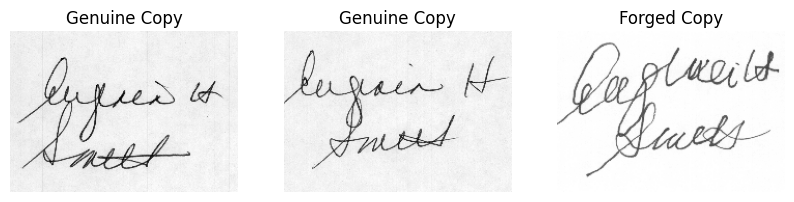

In [ ]:
visualize_sample_signature()

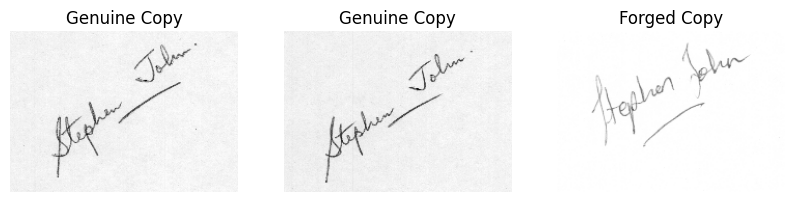

In [ ]:
visualize_sample_signature()

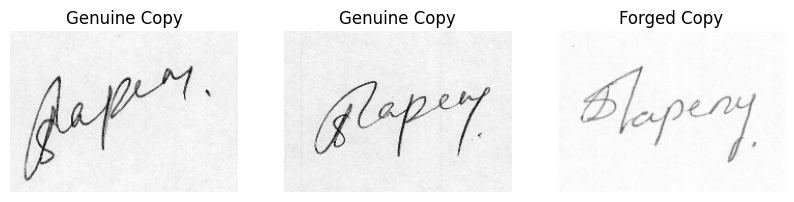

In [ ]:
visualize_sample_signature()

In [ ]:
import threading
def generate_batch(orig_groups, forg_groups, batch_size = 128):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''

    lock = threading.Lock()
    with lock:
      while True:
          orig_pairs = []
          forg_pairs = []
          gen_gen_labels = []
          gen_for_labels = []
          all_pairs = []
          all_labels = []

          # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
          # For every person we have 24 genuine signatures, hence we have
          # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
          # To make Genuine-Forged pairs, we pair every Genuine signature of a person
          # with 12 randomly sampled Forged signatures of the same person.
          # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
          # In all we have 120 person's data in the training data.
          # Total no. of Genuine-Genuine pairs = 120 * 276 = 33120
          # Total number of Genuine-Forged pairs = 120 * 300 = 36000
          # Total no. of data points = 33120 + 36000 = 69120
          for orig, forg in zip(orig_groups, forg_groups):
              orig_pairs.extend(list(itertools.combinations(orig, 2)))
              for i in range(len(forg)):
                  forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))

          # Label for Genuine-Genuine pairs is 1
          # Label for Genuine-Forged pairs is 0
          gen_gen_labels = [1]*len(orig_pairs)
          gen_for_labels = [0]*len(forg_pairs)

          # Concatenate all the pairs together along with their labels and shuffle them
          all_pairs = orig_pairs + forg_pairs

          all_labels = gen_gen_labels + gen_for_labels
          del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
          all_pairs, all_labels = shuffle(all_pairs, all_labels)

          # Note the lists above contain only the image names and
          # actual images are loaded and yielded below in batches
          # Below we prepare a batch of data points and yield the batch
          # In each batch we load "batch_size" number of image pairs
          # These images are then removed from the original set so that
          # they are not added again in the next batch.

          k = 0
          pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
          targets=np.zeros((batch_size,))
          for ix, pair in enumerate(all_pairs):
              img1 = cv2.imread(pair[0], 0)
              img2 = cv2.imread(pair[1], 0)
              img1 = cv2.resize(img1, (img_w, img_h))
              img2 = cv2.resize(img2, (img_w, img_h))
              img1 = np.array(img1, dtype = np.float64)
              img2 = np.array(img2, dtype = np.float64)
              img1 /= 255
              img2 /= 255
              img1 = img1[..., np.newaxis]
              img2 = img2[..., np.newaxis]
              pairs[0][k, :, :, :] = img1
              pairs[1][k, :, :, :] = img2
              targets[k] = all_labels[ix]
              k += 1
              if k == batch_size:
                  yield pairs, targets
                  k = 0
                  pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]


                  targets=np.zeros((batch_size,))

In [ ]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))



In [ ]:
def create_base_network_signet(input_shape):

    seq = Sequential()
    seq.add(Convolution2D(96, (11, 11), activation='relu', name='conv1_1', strides=(4,4), input_shape= input_shape,
                        kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(ZeroPadding2D((2, 2),))

    seq.add(Convolution2D(256, (5, 5), activation='relu', name='conv2_1', strides=(1, 1), kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1)))

    seq.add(Convolution2D(384, (3, 3), activation='relu', name='conv3_1', strides=(1, 1), kernel_initializer='glorot_uniform'))
    seq.add(ZeroPadding2D((1, 1)))

    seq.add(Convolution2D(256, (3, 3), activation='relu', name='conv3_2', strides=(1, 1), kernel_initializer='glorot_uniform'))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
#    model.add(SpatialPyramidPooling([1, 2, 4]))
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))

    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu

    print (seq.summary())
    return seq

def compute_accuracy_roc(predictions, labels):
   # Compute ROC accuracy with a range of thresholds on distances.
   dmax = np.max(predictions)
   dmin = np.min(predictions)
   nsame = np.sum(labels == 1)
   ndiff = np.sum(labels == 0)

   step = 0.01
   max_acc = 0

   for d in np.arange(dmin, dmax+step, step):
       idx1 = predictions.ravel() <= d
       idx2 = predictions.ravel() > d

       tpr = float(np.sum(labels[idx1] == 1)) / nsame
       tnr = float(np.sum(labels[idx2] == 0)) / ndiff
       acc = 0.5 * (tpr + tnr)
#       print ('ROC', acc, tpr, tnr)

       if (acc > max_acc):
           max_acc = acc

   return max_acc

def compute_accuracy(predictions, labels):
    """ Compute classification accuracy with a fixed threshold on distances.
    """
    return labels[predictions.ravel() < 0.5].mean()
    # return np.mean(labels==(predictions.ravel() > 0.5))



In [ ]:
input_shape=(img_h, img_w, 1)

In [ ]:
# istance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

# model = Model(inputs=[input_a, input_b], outputs=distance)

# # compile model
# rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
# adadelta = Adadelta()
# model.compile(loss=contrastive_loss, optimizer=rms)
# model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size=batch_size, epochs=epochs)
# model.save('../SiameseData/Signet_Models/cedar_original/model.h5')
# #

In [ ]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

Instructions for updating:
Colocations handled automatically by placer.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 37, 53, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 37, 53, 96)       148       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 26, 96)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 22, 30, 96)       0         
 2D)                                                             
                                                                 
 conv2_1 (Conv2D)            (None, 18, 26, 256)       614656    
                                                        

In [ ]:
batch_sz = 128
num_train_samples = 24*len(orig_train) + 24*len(forg_train)
num_val_samples, num_test_samples = (24*len(orig_val) + 24*len(forg_val)), (24*(len(orig_test)) + 24*(len(forg_test)))
num_train_samples, num_val_samples, num_test_samples

(1440, 480, 720)

In [ ]:
# batch_sz = 128

In [ ]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/signet-cedar-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
orig_train;

In [ ]:
results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 13,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/13


<ipython-input-60-f71a60bc10b3>:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),


11/11 [==============================] - ETA: 0s - batch: 5.0000 - size: 128.0000 - loss: 1.0596
Epoch 1: saving model to ./Weights/signet-cedar-001.h5
11/11 [==============================] - 16s 1s/step - batch: 5.0000 - size: 128.0000 - loss: 1.0596 - val_loss: 1.2565 - lr: 1.0000e-04
Epoch 2/13
11/11 [==============================] - ETA: 0s - batch: 5.0000 - size: 128.0000 - loss: 1.0080
Epoch 2: saving model to ./Weights/signet-cedar-002.h5
11/11 [==============================] - 12s 1s/step - batch: 5.0000 - size: 128.0000 - loss: 1.0080 - val_loss: 1.2397 - lr: 1.0000e-04
Epoch 3/13
11/11 [==============================] - ETA: 0s - batch: 5.0000 - size: 128.0000 - loss: 0.9661
Epoch 3: saving model to ./Weights/signet-cedar-003.h5
11/11 [==============================] - 13s 1s/step - batch: 5.0000 - size: 128.0000 - loss: 0.9661 - val_loss: 1.1821 - lr: 1.0000e-04
Epoch 4/13
11/11 [==============================] - ETA: 0s - batch: 5.0000 - size: 128.0000 - loss: 0.9447
Epo

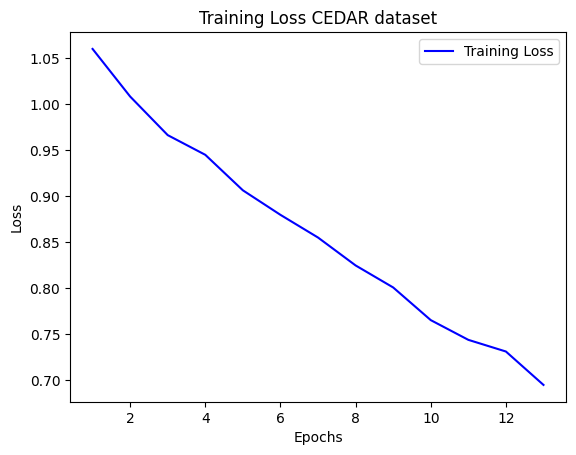

In [ ]:
# Extract loss values and epoch numbers from history
loss_values = results.history['loss']
epochs = range(1, len(loss_values) + 1)

# Plot the loss over epochs
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.title('Training Loss CEDAR dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)

    step = 0.01
    max_acc = 0
    best_thresh = -1

    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d

        tpr = float(np.sum(labels[idx1] == 1)) / nsame
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)
#       print ('ROC', acc, tpr, tnr)

        if (acc > max_acc):
            max_acc, best_thresh = acc, d

    return max_acc, best_thresh

In [ ]:
model.load_weights('./Weights/signet-cedar-013.h5')

In [ ]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [ ]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.9027777777777778, 0.02260441843420267)

In [ ]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

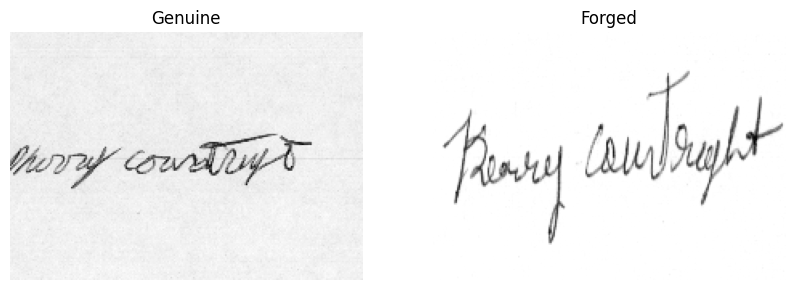

Difference Score =  0.041384876
Its a Forged Signature


In [ ]:
predict_score()

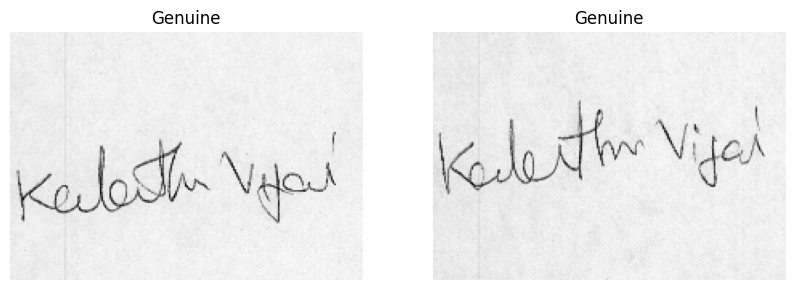

Difference Score =  0.009615091
Its a Genuine Signature


In [ ]:
predict_score()

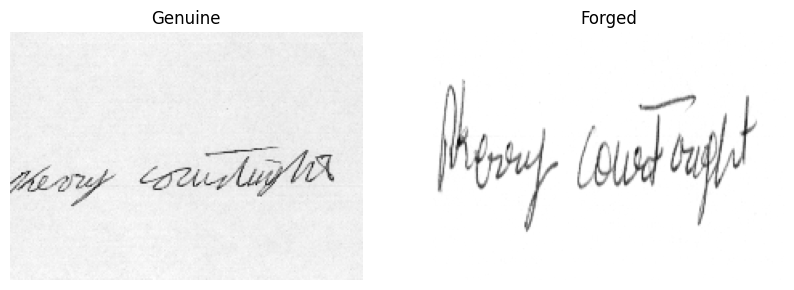

Difference Score =  0.035830904
Its a Forged Signature


In [ ]:
predict_score()

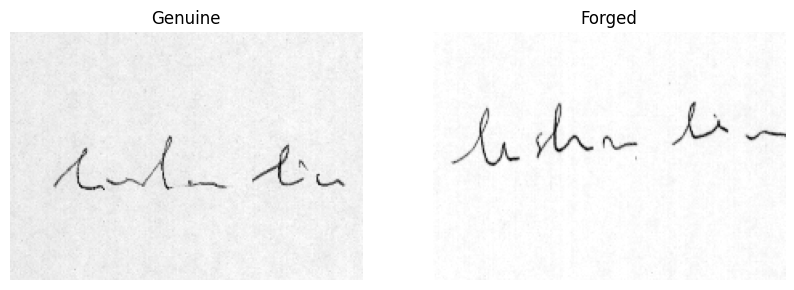

Difference Score =  0.0315376
Its a Forged Signature


In [ ]:
predict_score()

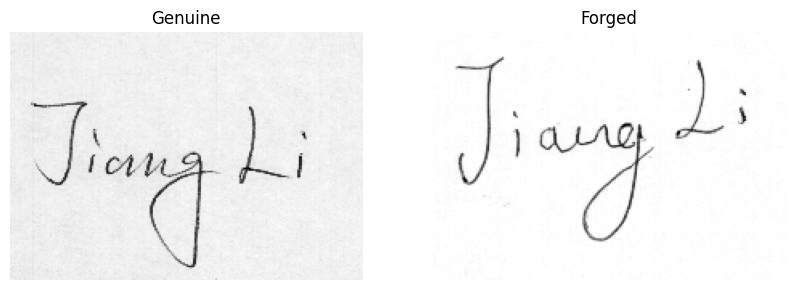

Difference Score =  0.03463812
Its a Forged Signature


In [ ]:
predict_score()

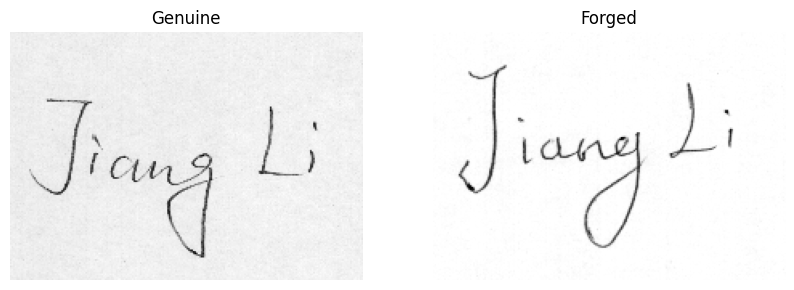

Difference Score =  0.03461129
Its a Forged Signature


In [ ]:
predict_score()